In [17]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot       as plt
import seaborn                 as sns

import pandas                  as pd
from pandas_profiling          import ProfileReport
import numpy                   as np
from sklearn.model_selection   import train_test_split
from sklearn.base              import BaseEstimator, TransformerMixin
from sklearn.metrics           import classification_report, f1_score
from sklearn                   import set_config
from sklearn                   import datasets
from sklearn                   import ensemble, neighbors,linear_model,svm
from scipy.stats               import zscore
from IPython.utils             import io
import eli5

set_config(display='diagram')
#datasets.load*?

In [18]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target']  = pd.Series(sklearn_dataset.target)
    return df

In [105]:
#df = sklearn_to_df(datasets.load_wine())
#df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
#df = pd.read_pickle('output/load_wine/04 PCA_5')
target = 'target'
drop_columns = []

In [106]:
df.head()

,alcohol,alcalinity_of_ash,nonflavanoid_phenols,proanthocyanins,hue,proline,kmean_clust,target
0,1.518613,-1.169593,-0.659563,1.224884,0.362177,1.013009,2,0
1,0.246290,-2.490847,-0.820719,-0.544721,0.406051,0.965242,2,0
2,0.196879,-0.268738,-0.498407,2.135968,0.318304,1.395148,2,0
3,1.691550,-0.809251,-0.981875,1.032155,-0.427544,2.334574,2,0
4,0.295700,0.451946,0.226796,0.401404,0.362177,-0.037874,0,0


In [107]:
# Input_df = pd.read_csv('input/pima.csv')
# target = 'class'
# drop_columns = ['skin','Pres']
# df = Input_df.drop(drop_columns, axis = 1)

In [108]:
if df[target].dtypes == np.object:    
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features  = df.select_dtypes(include=['object']).drop(target, axis=1).columns
else:
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).drop(target, axis=1).columns
    categorical_features  = df.select_dtypes(include=['object']).columns
    
X = df.drop((target),axis = 'columns')
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3,random_state =1)

In [109]:
#ProfileReport(df)

In [110]:
# train_values = pd.read_csv('train_values.csv')
# train_labels = pd.read_csv('train_labels.csv')
# train_data = train_values.merge(train_labels, left_on='building_id', right_on='building_id')

# train_data = train_data.drop('building_id', axis=1)
# numeric_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['damage_grade'], axis=1).columns
# categorical_features = train_data.select_dtypes(include=['object']).columns
# X = train_data.drop('damage_grade', axis=1)
# y = train_data['damage_grade']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [111]:
from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import OneHotEncoder,StandardScaler,PolynomialFeatures,MinMaxScaler
from sklearn.compose            import ColumnTransformer
from sklearn                    import ensemble, neighbors,linear_model,svm
from sklearn.feature_selection  import SelectFromModel
from sklearn.model_selection    import cross_val_score
from sklearn.decomposition      import PCA


numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    #('feature_selection',SelectFromModel(svm.LinearSVC(penalty = 'l1',dual = False))),
    #('scaler', StandardScaler()),
    #('scaler',MinMaxScaler()),
    ('poly', PolynomialFeatures(degree = 2,interaction_only = True)),
    #('PCA_decomposition', PCA(n_components = 3))
    ])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('one_hot', OneHotEncoder()),
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model',  ensemble.RandomForestRegressor(max_depth = 3))])
    
#model = pipe.fit(X_train, y_train)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['alcohol', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'proanthocyanins', 'hue', 'proline'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('model', RandomForestRegressor(max_depth=3))])

In [112]:
model_list = [#regressors
                linear_model.LinearRegression(),linear_model.Lasso(),linear_model.Ridge(),svm.SVR(),
              
              #ensembling - regressors
                ensemble.RandomForestRegressor(max_depth = 3),ensemble.AdaBoostRegressor(),ensemble.GradientBoostingRegressor(),
    
              #classifiers
                linear_model.LogisticRegression(max_iter = 500), neighbors.KNeighborsClassifier(),svm.SVC(),             
    
              #ensembling - classifiers
                ensemble.RandomForestClassifier(n_estimators=500,max_depth = 3),ensemble.AdaBoostClassifier(learning_rate=0.5),ensemble.GradientBoostingClassifier(n_estimators = 200)

              ]

In [113]:
rejected_models = []
results = []
print('{:30s}Train  /  Test   /  Cross Validation'.format('Model'))
print('-----------------------------------------------------------------')
for model in model_list:
    pipe                 = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    try:        
        with io.capture_output() as captured:
            pipe.fit(X_train,y_train);
        model_name       = type(model).__name__
        train_results    = np.abs(pipe.score(X_train,y_train))
        test_results     = np.abs(pipe.score(X_test,y_test))
        cross_val_scores = np.abs(cross_val_score(pipe, X, y, cv=5)) 
        cval_score       = cross_val_scores.mean()

        results.append([model_name, train_results, test_results,cval_score])
        print('{:30s}{:.4f} / {:.4f}  /  {:.4f} '.format(model_name, train_results, test_results,cval_score))

    except:
        rejected_models.append(type(model).__name__)

df_results = pd.DataFrame(results, columns=["Model", "Train Results","Test Results",'Test Cross Validation Results'])

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------------
LinearRegression              0.8372 / 0.7821  /  0.1079 
Lasso                         0.0000 / 0.0684  /  0.7028 
Ridge                         0.8372 / 0.7838  /  0.1113 
SVR                           0.9594 / 0.8865  /  0.2434 
RandomForestRegressor         0.9420 / 0.8280  /  0.0684 
AdaBoostRegressor             0.9997 / 0.9349  /  0.2297 
GradientBoostingRegressor     0.9998 / 0.8602  /  0.1132 
LogisticRegression            0.9839 / 0.9630  /  0.9386 
KNeighborsClassifier          0.9758 / 0.9815  /  0.9610 
SVC                           0.9677 / 0.9630  /  0.9106 
RandomForestClassifier        0.9919 / 0.9444  /  0.9216 
AdaBoostClassifier            0.9758 / 0.9444  /  0.9103 
GradientBoostingClassifier    1.0000 / 0.9444  /  0.8825 


In [114]:
print('\n')
if rejected_models == []:
    print('No models rejected')
else:    
    print('Rejected Models list: ')
    for rej_models in rejected_models:
        print('  - ',rej_models)



No models rejected


In [115]:
def highlight_range(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    #threshold = 0.95
    #val = s > threshold
    return ['background-color: lightgreen' if v else '' for v in is_max]

df_results.sort_values(by = 'Test Cross Validation Results',ascending = False)\
.style.apply(highlight_range,subset=pd.IndexSlice[:, ['Train Results', 'Test Results', 'Test Cross Validation Results']]).set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Train Results,Test Results,Test Cross Validation Results
8,KNeighborsClassifier,0.975806,0.981481,0.960952
7,LogisticRegression,0.983871,0.962963,0.938571
10,RandomForestClassifier,0.991935,0.944444,0.921587
9,SVC,0.967742,0.962963,0.910635
11,AdaBoostClassifier,0.975806,0.944444,0.910317
12,GradientBoostingClassifier,1.000000,0.944444,0.882540
1,Lasso,0.000000,0.068400,0.702759
3,SVR,0.959356,0.886474,0.243370
5,AdaBoostRegressor,0.999718,0.934919,0.229736
6,GradientBoostingRegressor,0.999793,0.860170,0.113211


In [15]:
# def main():

#     data = read_data_from_web()

#     modified_data = process_data(data)

#     write_data_to_database(modified_data)


# if __name__ == "__main__":

#     main()

### Feature Selection

In [40]:
# try:
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),('model',  ensemble.RandomForestRegressor(max_depth = 3))])
#     pipe.fit(X_train,y_train)
# except:
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),('model',  ensemble.RandomForestClassifier(max_depth = 3))])
#     pipe.fit(X_train,y_train)

# try:
#     onehot_columns = list(pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot']
#                           .get_feature_names(input_features=categorical_features))
# except:
#     onehot_columns = []

# numeric_features_list = list(numeric_features)
# numeric_features_list.extend(onehot_columns)
# eli5.explain_weights(pipe.named_steps['model'], top=10, feature_names=numeric_features_list)

### TroubleShoot

In [41]:
# rejected_models = []
# results = []
# print('{:30s}Train  /  Test   /  Cross Validation'.format('Model'))
# print('-----------------------------------------------------------')
# for model in model_list:
#     pipe                 = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])   
#     pipe.fit(X_train,y_train)
#     model_name       = type(model).__name__
#     train_results    = np.abs(pipe.score(X_train,y_train))
#     test_results     = np.abs(pipe.score(X_test,y_test))
#     cross_val_scores = np.abs(cross_val_score(pipe, X, y, cv=5)) 
#     cval_score       = cross_val_scores.mean()

#     print('{:30s}{:.4f} / {:.4f}  /  {:.4f} '.format(model_name, train_results, test_results,cval_score))

In [42]:
#sns.pairplot(df,diag_kind = 'kde',hue = target);

In [43]:
# def highlight_range(s):
#     '''
#     highlight the maximum in a Series green.
#     '''
#     is_max = s == s.max()
#     threshold = 0.1
#     val = s < threshold
#     return ['background-color: lightgreen' if v else '' for v in val]

# df.corr().style.apply(highlight_range)

## PCA

In [44]:
# from sklearn.decomposition import PCA

# X_scaled = StandardScaler(X)
# pca3 = PCA(n_components=6)
# pca3.fit(X)
# #print(pca3.components_)
# print(pca3.explained_variance_ratio_)
# Xpca3 = pca3.transform(X)

PCA(n_components=6)

[9.23461446e-01 6.32362819e-02 8.77055987e-03 3.98985604e-03
 5.34691142e-04 7.16472325e-06]


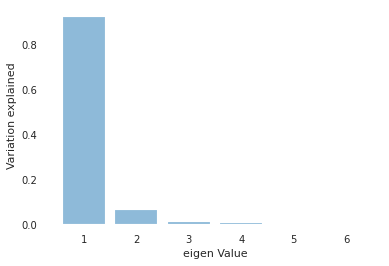

In [45]:
# plt.bar(list(range(1,7)),pca3.explained_variance_ratio_,alpha=0.5, align='center');
# plt.ylabel('Variation explained');
# plt.xlabel('eigen Value');
# plt.show();

In [46]:
# plt.step(list(range(1,7)),np.cumsum(pca3.explained_variance_ratio_), where='mid')
# plt.ylabel('Cum of variation explained')
# plt.xlabel('eigen Value')
# plt.show()